# test2：GSE163018_scRNA-seq_cerebral_organoid_cca

Title: Single cell epigenomics reveals mechanisms of human cortical development\
We performed scATAC-seq and scRNA-seq on cortical organoids derived from 3 human pluripotent stem cell lines (13234, H28126, H1; 2 genetically normal human induced PSC lines, H28126 and 13234, and the embryonic stem cell line H1) at three different timepoints of differentiation using the 10x Genomics Chromium Gene Expression and ATAC solutions. We performed a separate experiment with 13234-derived cerebral organoids in which 3 different treatment condiitons were used (Vitamin A treatment, no Vitamin A, and DEAB). These organoids were processed at 10 weeks for scRNA-seq using the 10x Genomics Chromium Gene Expression solution.

In [ ]:
mkdir -p GSE163018
cd GSE163018
wget "https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE163018&format=file" -O GSE163018_RAW.tar
#ターミナルで実行
tar -xvf GSE163018_RAW.tar

mkdir -p GSM4970299_organoid_H1_scRNA
mv GSM4970299_organoid_H1_scRNA_* GSM4970299_organoid_H1_scRNA/
gunzip GSM4970299_organoid_H1_scRNA/GSM4970299_organoid_H1_scRNA_*
→解凍しちゃダメ
gzip GSM4970299_organoid_H1_scRNA/GSM4970299_organoid_H1_scRNA_*
data=GSM4970299_organoid_H1_scRNA
mv ${data}/${data}_barcodes.tsv.gz ${data}/barcodes.tsv.gz
mv ${data}/${data}_features.tsv.gz ${data}/features.tsv.gz
mv ${data}/${data}_matrix.mtx.gz ${data}/matrix.mtx.gz

mkdir -p GSM4970298_organoid_H28126_scRNA
mv GSM4970298_organoid_H28126_scRNA_* GSM4970298_organoid_H28126_scRNA/
gunzip GSM4970298_organoid_H28126_scRNA/GSM4970298_organoid_H28126_scRNA_*
gzip GSM4970298_organoid_H28126_scRNA/GSM4970298_organoid_H28126_scRNA_*
data=GSM4970298_organoid_H28126_scRNA
mv ${data}/${data}_barcodes.tsv.gz ${data}/barcodes.tsv.gz
mv ${data}/${data}_features.tsv.gz ${data}/features.tsv.gz
mv ${data}/${data}_matrix.mtx.gz ${data}/matrix.mtx.gz

data=GSM4970302_org_VitACtrlDEAB_well1
mkdir -p ${data}
mv ${data}_barcodes.tsv.gz ${data}/barcodes.tsv.gz
mv ${data}_features.tsv.gz ${data}/features.tsv.gz
mv ${data}_matrix.mtx.gz ${data}/matrix.mtx.gz

mkdir -p /home/oguma/work/seurat/test1_GSE163018_scRNA-seq_cerebral_organoid_integrate

In [1]:
#R
setwd("~/work/seurat")
.libPaths("~/R_4.3_library")

options(repr.plot.width=10, repr.plot.height=6)

In [22]:
library(tidyverse)
library(Seurat)
library(patchwork)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.5
✔ ggplot2   3.5.1     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [3]:
out_f="/home/oguma/work/seurat/test2_GSE163018_scRNA-seq_cerebral_organoid_integrate_cca"
out_f_plot <- paste0(out_f,"/plot")
out_f_SeuratObject <- paste0(out_f,"/SeuratObject")
out_f_genelist <- paste0(out_f,"/genelist")

In [5]:
dir.create(out_f)
dir.create(out_f_plot)
dir.create(out_f_SeuratObject)
dir.create(out_f_genelist)

### after_norm
データの読み込み
- CreateSeuratObject(counts = data, project = "GSE163018", min.cells = 3, min.features = 200)

QC（各細胞で検出された遺伝子数が200より多く2500未満で、ミトコンドリアリードの割合が全体の5%未満の細胞のみ保持）
- subset(SeuratObject, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 5)
- filter cells that have unique feature counts over 2,500 or less than 200
- filter cells that have >5% mitochondrial counts

Normalization
- NormalizeData(pbmc, normalization.method = "LogNormalize", scale.factor = 10000): デフォルトの正規化手法で、発現の合計で割り算し、スケールファクター（デフォルトでは10000）をかけた後、対数変換

### after_analysis
Identification of highly variable features
- FindVariableFeatures(pbmc, selection.method = "vst", nfeatures = 2000)：選択した方法を使用して変動の大きい遺伝子を特定する。 細胞間の平均と分散の関係を直接モデル化。（デフォルト：selection method: vst, nfeatures: 2,000個）

Scaling
- ScaleData(SeuratObject, features = all.genes)：PCAなどの次元削減手法の実行前に標準的な前処理。
- 平均0, 分散1に正規化→下流の解析で同じ重みをもつ（高発現の遺伝子が支配的にならないように）（all.genes <- rownames(SeuratObject)SeuratObject）（By default, only variable features are scaled.）

PCA
- SeuratObject <- RunPCA(SeuratObject, features = VariableFeatures(object = SeuratObject))
（デフォルトでは、変動の大きい特徴のみが入力として使用される。）

Clustering
- FindNeighbors(SeuratObject, dims = 1:30)：近傍グラフ(K-nearest neighbor (KNN) graph)の作成。PCA空間におけるユークリッド距離に基づいてKNNグラフを構築し、ローカルな近傍領域における重複部分の共有度(Jaccard類似度)に基づいて任意の2つのセル間のエッジの重みを調整する。（PC1~30を使用）
- FindClusters(SeuratObject, resolution = 0.8)：Louvain(SLM)アルゴリズムにより、細胞間のグラフをクラスター(コミュニティ)に分割。（デフォルト：resolution = 0.8）

UMAP（non-linear dimensional reduction）
- RunUMAP(SeuratObject, dims = 1:30)

# データの読み込み→UMAP

## GSM4970298_organoid_H28126_scRNA
genetically normal human induced PSC line

In [44]:
# Load the dataset
GSM4970298_H28126.data <- Read10X(data.dir = "/home/oguma/work/seurat/GSE163018/GSM4970298_organoid_H28126_scRNA/")
# Initialize the Seurat object with the raw (non-normalized data).
GSM4970298_H28126 <- CreateSeuratObject(counts = GSM4970298_H28126.data, project = "GSM4970298_H28126", min.cells = 3, min.features = 200)
GSM4970298_H28126

An object of class Seurat 
19313 features across 8295 samples within 1 assay 
Active assay: RNA (19313 features, 0 variable features)
 1 layer present: counts

In [45]:
GSM4970298_H28126_after_norm <- GSM4970298_H28126 %>%
    PercentageFeatureSet(pattern = "^MT-", col.name = "percent.mt") %>%
    subset(subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 5) %>%
    NormalizeData()

Normalizing layer: counts



In [46]:
GSM4970298_H28126 %>%
    PercentageFeatureSet(pattern = "^MT-", col.name = "percent.mt") %>%
    subset(subset = percent.mt > 5)
#8295 samplesのうち431 samples, 5.2%

An object of class Seurat 
19313 features across 431 samples within 1 assay 
Active assay: RNA (19313 features, 0 variable features)
 1 layer present: counts

In [47]:
GSM4970298_H28126_after_norm
str(GSM4970298_H28126_after_norm)
saveRDS(GSM4970298_H28126_after_norm, file = paste0(out_f_SeuratObject,"/GSM4970298_H28126_after_norm.rds"))

An object of class Seurat 
19313 features across 6450 samples within 1 assay 
Active assay: RNA (19313 features, 0 variable features)
 2 layers present: counts, data

Formal class 'Seurat' [package "SeuratObject"] with 13 slots
  ..@ assays      :List of 1
  .. ..$ RNA:Formal class 'Assay5' [package "SeuratObject"] with 8 slots
  .. .. .. ..@ layers    :List of 2
  .. .. .. .. ..$ counts:Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. .. .. .. .. .. ..@ i       : int [1:8837172] 33 66 69 96 102 107 108 120 123 132 ...
  .. .. .. .. .. .. ..@ p       : int [1:6451] 0 1662 2471 3936 5098 7516 9304 10262 10667 11415 ...
  .. .. .. .. .. .. ..@ Dim     : int [1:2] 19313 6450
  .. .. .. .. .. .. ..@ Dimnames:List of 2
  .. .. .. .. .. .. .. ..$ : NULL
  .. .. .. .. .. .. .. ..$ : NULL
  .. .. .. .. .. .. ..@ x       : num [1:8837172] 1 1 1 15 1 1 1 1 2 2 ...
  .. .. .. .. .. .. ..@ factors : list()
  .. .. .. .. ..$ data  :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. .. .. .. .. .. ..@ i       : int [1:8837172] 33 66 69 96 102 107 108 120 123 132 ...
  .. .. .. .. .. .. ..@ p       : int [1:6451] 0 1662 2471 3936 5098 7516 

Finding variable features for layer counts

Centering and scaling data matrix

PC_ 1 
Positive:  HMGB2, NUSAP1, TOP2A, TUBA1B, MAD2L1, SMC4, PCLAF, PBK, CENPU, CDK1 
	   HMGN2, CENPF, ANP32E, BIRC5, PTTG1, NUF2, CCNA2, UBE2C, SMC2, HMGB1 
	   PRC1, CKS1B, TPX2, CCNB2, SGO1, KIFC1, NDC80, PIMREG, UBE2T, MKI67 
Negative:  GPM6A, RTN1, NSG2, SYT1, NEUROD6, NSG1, SOX4, CXADR, STMN2, SLA 
	   RAB3A, MEIS2, GRIA2, GNG3, SEZ6L2, BHLHE22, MEF2C, MAPT, RUNX1T1, STMN4 
	   LINC01405, AC004158.1, BEX2, MYT1L, PALMD, ARPP21, TLE4, NEUROD2, GUCY1A1, RBFOX1 
PC_ 2 
Positive:  HES1, PTN, CLU, ZFP36L1, SLC1A3, PMP2, HOPX, PTPRZ1, MT2A, BCAN 
	   B2M, FABP7, DBI, DOK5, VIM, PON2, SPARC, ID3, CDO1, FAM107A 
	   GPM6B, CRYAB, S100B, GFAP, CD63, PEA15, ADGRV1, GPX3, FOS, TFPI 
Negative:  STMN1, TUBB, STMN2, SOX4, TMSB10, DLX6-AS1, PTMA, DLX5, ACTB, TUBA1A 
	   TUBB2A, SOX11, NREP, GAD2, RTN1, ARL4D, NNAT, SHTN1, CALM2, ACTG1 
	   TMSB15A, CHCHD2, HSPA1A, RAB3A, UBE2C, HMGB3, HNRNPA1, RND3, PRC1, CCNA2 
PC

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 6450
Number of edges: 272571

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8557
Number of communities: 14
Elapsed time: 0 seconds


14:06:50 UMAP embedding parameters a = 0.9922 b = 1.112

14:06:50 Read 6450 rows and found 30 numeric columns

14:06:50 Using Annoy for neighbor search, n_neighbors = 30

14:06:50 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

14:06:50 Writing NN index file to temp file /tmp/Rtmpi5xPtv/file205d27252900d9

14:06:50 Searching Annoy index using 1 thread, search_k = 3000

14:06:52 Annoy recall = 100%

14:06:52 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

14:06:53 Initializing from normalized Laplacian + noise (using RSpectra)

14:06:53 Commencing optimization for 500 epochs, with 277006 positive edges

14:07:01 Optimization finished



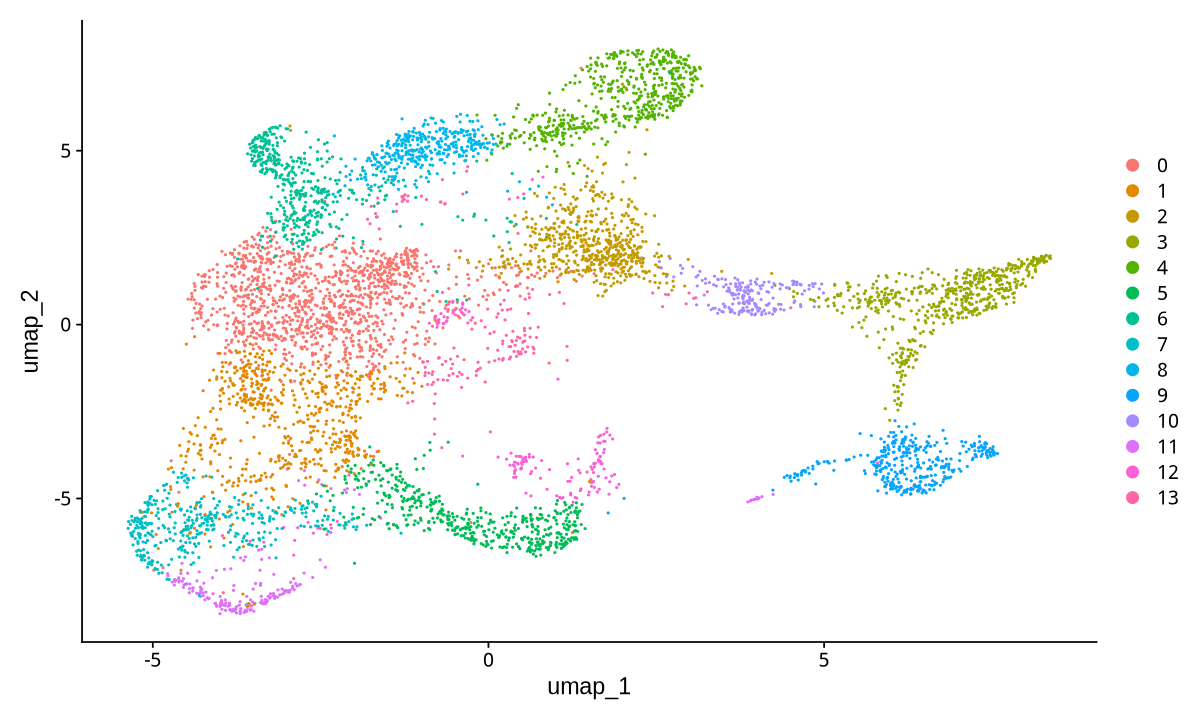

In [48]:
all.genes <- rownames(GSM4970298_H28126_after_norm)

GSM4970298_H28126_after_analysis <- GSM4970298_H28126_after_norm %>%
    FindVariableFeatures() %>%
    ScaleData(features = all.genes) %>%

    RunPCA() %>%
    FindNeighbors(dims = 1:30) %>%
    FindClusters() %>%
    RunUMAP(dims = 1:30)

DimPlot(object = GSM4970298_H28126_after_analysis, reduction = "umap")
##FindClusters()関数のresolution引数のdefaultは0.8。

In [49]:
GSM4970298_H28126_after_analysis
str(GSM4970298_H28126_after_analysis)
saveRDS(GSM4970298_H28126_after_analysis, file = paste0(out_f_SeuratObject,"/GSM4970298_H28126_after_analysis.rds"))

An object of class Seurat 
19313 features across 6450 samples within 1 assay 
Active assay: RNA (19313 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 2 dimensional reductions calculated: pca, umap

Formal class 'Seurat' [package "SeuratObject"] with 13 slots
  ..@ assays      :List of 1
  .. ..$ RNA:Formal class 'Assay5' [package "SeuratObject"] with 8 slots
  .. .. .. ..@ layers    :List of 3
  .. .. .. .. ..$ counts    :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. .. .. .. .. .. ..@ i       : int [1:8837172] 33 66 69 96 102 107 108 120 123 132 ...
  .. .. .. .. .. .. ..@ p       : int [1:6451] 0 1662 2471 3936 5098 7516 9304 10262 10667 11415 ...
  .. .. .. .. .. .. ..@ Dim     : int [1:2] 19313 6450
  .. .. .. .. .. .. ..@ Dimnames:List of 2
  .. .. .. .. .. .. .. ..$ : NULL
  .. .. .. .. .. .. .. ..$ : NULL
  .. .. .. .. .. .. ..@ x       : num [1:8837172] 1 1 1 15 1 1 1 1 2 2 ...
  .. .. .. .. .. .. ..@ factors : list()
  .. .. .. .. ..$ data      :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. .. .. .. .. .. ..@ i       : int [1:8837172] 33 66 69 96 102 107 108 120 123 132 ...
  .. .. .. .. .. .. ..@ p       : int [1:6451] 0 1662 2471 3936 50

## GSM4970299_organoid_H1_scRNA
the embryonic stem cell line

In [50]:
# Load the dataset
GSM4970299_H1.data <- Read10X(data.dir = "/home/oguma/work/seurat/GSE163018/GSM4970299_organoid_H1_scRNA/")
# Initialize the Seurat object with the raw (non-normalized data).
GSM4970299_H1 <- CreateSeuratObject(counts = GSM4970299_H1.data, project = "GSM4970299_H1", min.cells = 3, min.features = 200)
GSM4970299_H1

An object of class Seurat 
20039 features across 7756 samples within 1 assay 
Active assay: RNA (20039 features, 0 variable features)
 1 layer present: counts

In [51]:
GSM4970299_H1_after_norm <- GSM4970299_H1 %>%
    PercentageFeatureSet(pattern = "^MT-", col.name = "percent.mt") %>%
    subset(subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 5) %>%
    NormalizeData()

Normalizing layer: counts



In [52]:
GSM4970299_H1_after_norm
str(GSM4970299_H1_after_norm)
saveRDS(GSM4970299_H1_after_norm, file = paste0(out_f_SeuratObject,"/GSM4970299_H1_after_norm.rds"))

An object of class Seurat 
20039 features across 5522 samples within 1 assay 
Active assay: RNA (20039 features, 0 variable features)
 2 layers present: counts, data

Formal class 'Seurat' [package "SeuratObject"] with 13 slots
  ..@ assays      :List of 1
  .. ..$ RNA:Formal class 'Assay5' [package "SeuratObject"] with 8 slots
  .. .. .. ..@ layers    :List of 2
  .. .. .. .. ..$ counts:Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. .. .. .. .. .. ..@ i       : int [1:9023649] 33 42 135 201 268 286 305 315 327 343 ...
  .. .. .. .. .. .. ..@ p       : int [1:5523] 0 634 2786 4164 6449 8456 10790 11788 13651 16037 ...
  .. .. .. .. .. .. ..@ Dim     : int [1:2] 20039 5522
  .. .. .. .. .. .. ..@ Dimnames:List of 2
  .. .. .. .. .. .. .. ..$ : NULL
  .. .. .. .. .. .. .. ..$ : NULL
  .. .. .. .. .. .. ..@ x       : num [1:9023649] 1 1 3 1 1 2 3 1 1 3 ...
  .. .. .. .. .. .. ..@ factors : list()
  .. .. .. .. ..$ data  :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. .. .. .. .. .. ..@ i       : int [1:9023649] 33 42 135 201 268 286 305 315 327 343 ...
  .. .. .. .. .. .. ..@ p       : int [1:5523] 0 634 2786 4164 6449 845

Finding variable features for layer counts

Centering and scaling data matrix

PC_ 1 
Positive:  STMN2, RTN1, MLLT11, SYT1, RAB3A, NEUROD6, TMSB10, NSG1, SOX4, TUBA1A 
	   SNAP25, GAP43, DCX, GPM6A, CXADR, CD24, LMO3, CAMKV, SCG3, NREP 
	   VAMP2, STMN1, NELL2, PDE1A, FAM49A, TUBB2A, MAPT, SHTN1, ATP6V1G2, NEUROD2 
Negative:  VIM, HMGB2, ZFP36L1, GAPDH, FABP7, SOX2, HMGN3, RPS27L, PCLAF, CLU 
	   PAX6, SOX9, MT2A, SRI, SLC1A3, C1orf61, TCIM, CD99, ANXA5, GNG5 
	   EEF1D, IFI44L, PHGDH, B2M, PTN, HSPB1, NUSAP1, PON2, CDCA7L, HMGN2 
PC_ 2 
Positive:  RPS4Y1, HMGB1, TUBA1B, HNRNPA2B1, TUBB, EIF3E, H2AFZ, RPS17, UBE2T, MIF 
	   HMGN2, MAD2L1, UBE2C, HMGB2, RPLP0, STMN1, CDK1, CCNA2, TUBB2A, CKS2 
	   PBK, NUSAP1, SPC25, BIRC5, HMGB3, SRSF7, PIMREG, TUBB2B, CALM2, PTTG1 
Negative:  PMP2, ZNF667-AS1, CRYAB, CCDC144NL-AS1, EMX2, CDKN1A, SCRG1, ZBTB20, GFAP, BHLHE22 
	   MTRNR2L1, CLU, GPX3, HOPX, AKR1C3, S100B, SNTG1, PKIB, MIR99AHG, LMO4 
	   NUPR1, B2M, SAT1, MROH8, LINC01405, ANXA1, TFPI, 

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 5522
Number of edges: 221714

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8567
Number of communities: 13
Elapsed time: 0 seconds


14:08:21 UMAP embedding parameters a = 0.9922 b = 1.112

14:08:21 Read 5522 rows and found 30 numeric columns

14:08:21 Using Annoy for neighbor search, n_neighbors = 30

14:08:21 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

14:08:21 Writing NN index file to temp file /tmp/Rtmpi5xPtv/file205d274521d1e9

14:08:21 Searching Annoy index using 1 thread, search_k = 3000

14:08:23 Annoy recall = 100%

14:08:23 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

14:08:24 Initializing from normalized Laplacian + noise (using RSpectra)

14:08:24 Commencing optimization for 500 epochs, with 232082 positive edges

14:08:31 Optimization finished



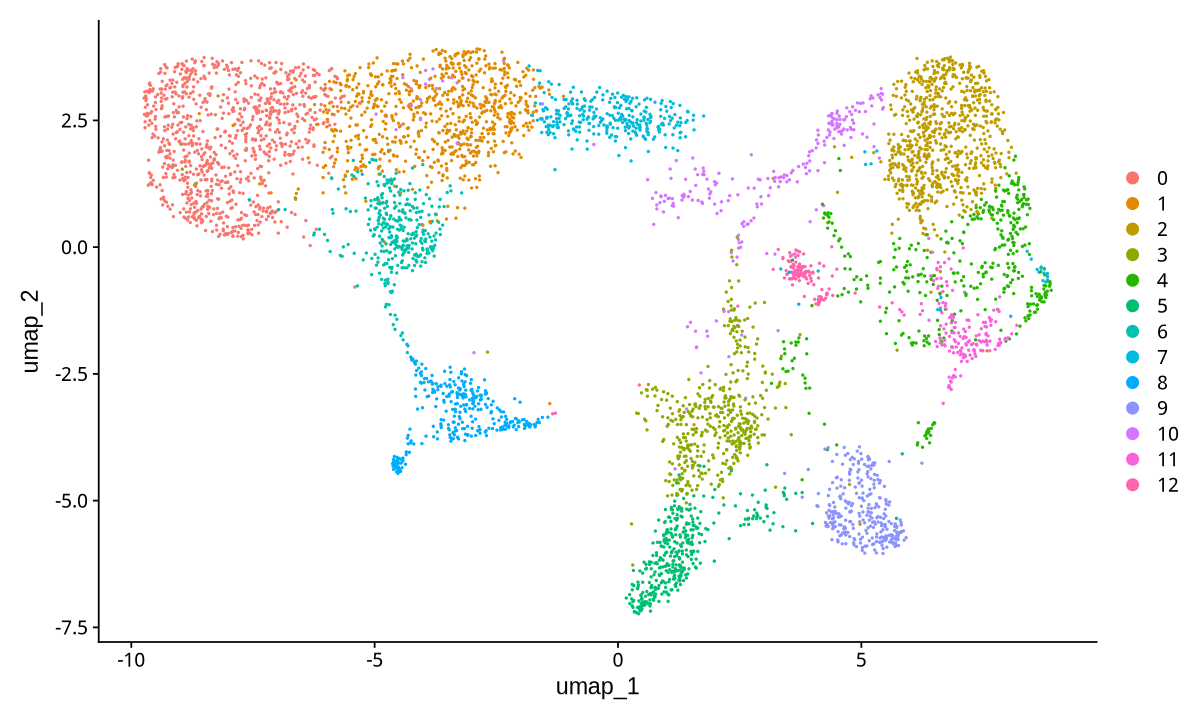

In [53]:
all.genes <- rownames(GSM4970299_H1_after_norm)

GSM4970299_H1_after_analysis <- GSM4970299_H1_after_norm %>%
    FindVariableFeatures() %>%
    ScaleData(features = all.genes) %>%

    RunPCA() %>%
    FindNeighbors(dims = 1:30) %>%
    FindClusters() %>%
    RunUMAP(dims = 1:30)

DimPlot(object = GSM4970299_H1_after_analysis, reduction = "umap")
##FindClusters()関数のresolution引数のdefaultは0.8。

In [54]:
GSM4970299_H1_after_analysis
str(GSM4970299_H1_after_analysis)
saveRDS(GSM4970299_H1_after_analysis, file = paste0(out_f_SeuratObject,"/GSM4970299_H1_after_analysis.rds"))

An object of class Seurat 
20039 features across 5522 samples within 1 assay 
Active assay: RNA (20039 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 2 dimensional reductions calculated: pca, umap

Formal class 'Seurat' [package "SeuratObject"] with 13 slots
  ..@ assays      :List of 1
  .. ..$ RNA:Formal class 'Assay5' [package "SeuratObject"] with 8 slots
  .. .. .. ..@ layers    :List of 3
  .. .. .. .. ..$ counts    :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. .. .. .. .. .. ..@ i       : int [1:9023649] 33 42 135 201 268 286 305 315 327 343 ...
  .. .. .. .. .. .. ..@ p       : int [1:5523] 0 634 2786 4164 6449 8456 10790 11788 13651 16037 ...
  .. .. .. .. .. .. ..@ Dim     : int [1:2] 20039 5522
  .. .. .. .. .. .. ..@ Dimnames:List of 2
  .. .. .. .. .. .. .. ..$ : NULL
  .. .. .. .. .. .. .. ..$ : NULL
  .. .. .. .. .. .. ..@ x       : num [1:9023649] 1 1 3 1 1 2 3 1 1 3 ...
  .. .. .. .. .. .. ..@ factors : list()
  .. .. .. .. ..$ data      :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. .. .. .. .. .. ..@ i       : int [1:9023649] 33 42 135 201 268 286 305 315 327 343 ...
  .. .. .. .. .. .. ..@ p       : int [1:5523] 0 634 2786 4164 

## GSM4970302_org_VitACtrlDEAB_well1
13234：genetically normal human induced PSC line\
Vitamin A treatment

In [55]:
# Load the dataset
GSM4970302_13234.data <- Read10X(data.dir = "/home/oguma/work/seurat/GSE163018/GSM4970302_org_VitACtrlDEAB_well1/")
# Initialize the Seurat object with the raw (non-normalized data).
GSM4970302_13234 <- CreateSeuratObject(counts = GSM4970302_13234.data, project = "GSM4970302_13234", min.cells = 3, min.features = 200)
GSM4970302_13234

An object of class Seurat 
23092 features across 11350 samples within 1 assay 
Active assay: RNA (23092 features, 0 variable features)
 1 layer present: counts

Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”


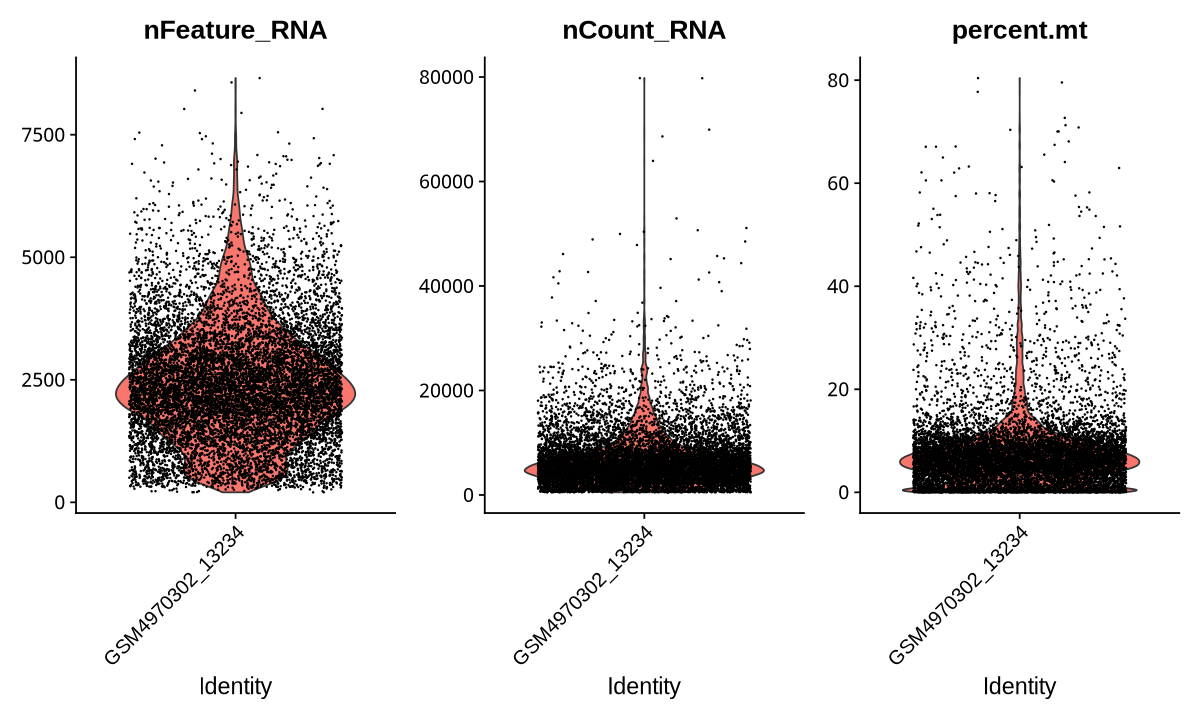

In [56]:
# Visualize QC metrics as a violin plot
VlnPlot(PercentageFeatureSet(GSM4970302_13234, pattern = "^MT-", col.name = "percent.mt"), features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

In [57]:
GSM4970302_13234 %>%
    PercentageFeatureSet(pattern = "^MT-", col.name = "percent.mt") %>%
    subset(subset = percent.mt > 5)
#11350 samplesのうち6730 samples, 59%がミトコンドリア由来の遺伝子発現が高い（低品質？）

An object of class Seurat 
23092 features across 6730 samples within 1 assay 
Active assay: RNA (23092 features, 0 variable features)
 1 layer present: counts

In [58]:
GSM4970302_13234_after_norm <- GSM4970302_13234 %>%
    PercentageFeatureSet(pattern = "^MT-", col.name = "percent.mt") %>%
    subset(subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 5) %>%
    NormalizeData()

Normalizing layer: counts



In [59]:
GSM4970302_13234_after_norm
str(GSM4970302_13234_after_norm)
saveRDS(GSM4970302_13234_after_norm, file = paste0(out_f_SeuratObject,"/GSM4970302_13234_after_norm.rds"))

An object of class Seurat 
23092 features across 2825 samples within 1 assay 
Active assay: RNA (23092 features, 0 variable features)
 2 layers present: counts, data

Formal class 'Seurat' [package "SeuratObject"] with 13 slots
  ..@ assays      :List of 1
  .. ..$ RNA:Formal class 'Assay5' [package "SeuratObject"] with 8 slots
  .. .. .. ..@ layers    :List of 2
  .. .. .. .. ..$ counts:Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. .. .. .. .. .. ..@ i       : int [1:4482805] 24 33 48 94 95 104 122 141 195 235 ...
  .. .. .. .. .. .. ..@ p       : int [1:2826] 0 755 2407 3465 5469 7816 9101 11453 12553 13530 ...
  .. .. .. .. .. .. ..@ Dim     : int [1:2] 23092 2825
  .. .. .. .. .. .. ..@ Dimnames:List of 2
  .. .. .. .. .. .. .. ..$ : NULL
  .. .. .. .. .. .. .. ..$ : NULL
  .. .. .. .. .. .. ..@ x       : num [1:4482805] 1 1 1 1 1 1 1 1 1 1 ...
  .. .. .. .. .. .. ..@ factors : list()
  .. .. .. .. ..$ data  :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. .. .. .. .. .. ..@ i       : int [1:4482805] 24 33 48 94 95 104 122 141 195 235 ...
  .. .. .. .. .. .. ..@ p       : int [1:2826] 0 755 2407 3465 5469 7816 9101 

Finding variable features for layer counts

Centering and scaling data matrix

PC_ 1 
Positive:  GRIA2, STMN2, GPM6A, SOX4, DCX, SYT1, LMO3, ARPP21, CELF4, PCDH9 
	   SOX11, GAP43, PCLO, NEUROD6, SHTN1, ADGRL3, NEUROD2, CNTNAP2, EPHA5, TBR1 
	   NBEA, VCAN, SMARCA2, ENC1, NTM, MEF2C, GRIA1, BHLHE22, ELAVL4, MIAT 
Negative:  VIM, FTL, RPL41, HSPB1, RPS19, TPT1, RPLP1, CLU, RPL13A, RPS27 
	   RPS20, RPS16, RPS6, RPS7, RPL8, RPS2, GAPDH, RPL13, RPL18A, EIF1 
	   RPL12, RPS15A, RPL5, RPL27A, RPLP0, RPL37, RPS18, GNG5, RPS12, RPS24 
PC_ 2 
Positive:  NEAT1, PLCG2, TSPYL2, GADD45B, DDIT3, RSRP1, AL118516.1, SNHG21, SPTY2D1, DNAJB1 
	   BRD2, HEXIM1, HERPUD1, SNHG9, HSPA6, SLC3A2, CSKMT, CREBRF, ATF3, CKS2 
	   HIST1H2BG, ZFAND2A, AC233280.1, AC044849.1, ZNF830, KMT2E-AS1, AL645728.1, SNHG19, HSPA1A, SLC38A2 
Negative:  TMSB4X, TUBA1A, RPL7A, RPL10, GAP43, RPL39, RPL3, GPM6A, RPL13, RPS3 
	   RPL23, RPS23, RACK1, DCX, RPS12, RPS24, NEUROD6, RPS15A, CAMK2N1, RPS19 
	   NNAT, C1orf61, RPS27, RP

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2825
Number of edges: 101891

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8562
Number of communities: 15
Elapsed time: 0 seconds


14:09:41 UMAP embedding parameters a = 0.9922 b = 1.112

14:09:41 Read 2825 rows and found 30 numeric columns

14:09:41 Using Annoy for neighbor search, n_neighbors = 30

14:09:41 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

14:09:41 Writing NN index file to temp file /tmp/Rtmpi5xPtv/file205d2754fb24fd

14:09:41 Searching Annoy index using 1 thread, search_k = 3000

14:09:42 Annoy recall = 100%

14:09:42 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

14:09:43 Initializing from normalized Laplacian + noise (using RSpectra)

14:09:43 Commencing optimization for 500 epochs, with 115292 positive edges

14:09:46 Optimization finished



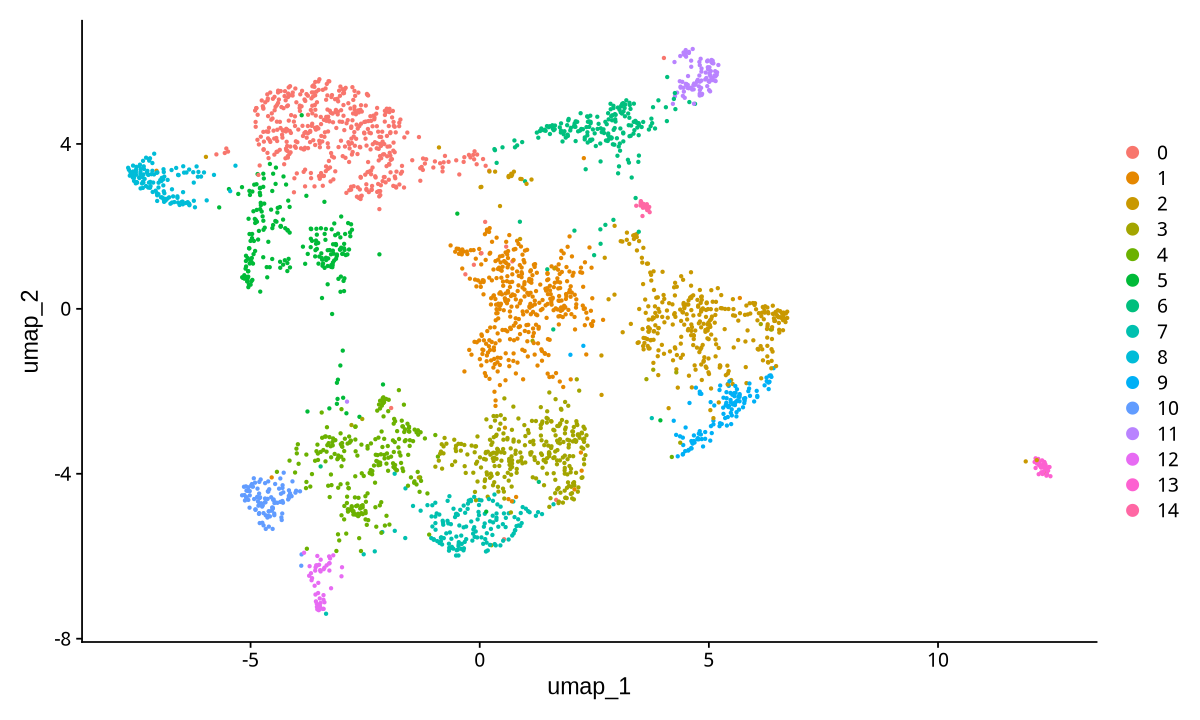

In [60]:
all.genes <- rownames(GSM4970302_13234_after_norm)

GSM4970302_13234_after_analysis <- GSM4970302_13234_after_norm %>%
    FindVariableFeatures() %>%
    ScaleData(features = all.genes) %>%

    RunPCA() %>%
    FindNeighbors(dims = 1:30) %>%
    FindClusters() %>%
    RunUMAP(dims = 1:30)

DimPlot(object = GSM4970302_13234_after_analysis, reduction = "umap")
##FindClusters()関数のresolution引数のdefaultは0.8。

In [61]:
GSM4970302_13234_after_analysis
str(GSM4970302_13234_after_analysis)
saveRDS(GSM4970302_13234_after_analysis, file = paste0(out_f_SeuratObject,"/GSM4970302_13234_after_analysis.rds"))

An object of class Seurat 
23092 features across 2825 samples within 1 assay 
Active assay: RNA (23092 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 2 dimensional reductions calculated: pca, umap

Formal class 'Seurat' [package "SeuratObject"] with 13 slots
  ..@ assays      :List of 1
  .. ..$ RNA:Formal class 'Assay5' [package "SeuratObject"] with 8 slots
  .. .. .. ..@ layers    :List of 3
  .. .. .. .. ..$ counts    :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. .. .. .. .. .. ..@ i       : int [1:4482805] 24 33 48 94 95 104 122 141 195 235 ...
  .. .. .. .. .. .. ..@ p       : int [1:2826] 0 755 2407 3465 5469 7816 9101 11453 12553 13530 ...
  .. .. .. .. .. .. ..@ Dim     : int [1:2] 23092 2825
  .. .. .. .. .. .. ..@ Dimnames:List of 2
  .. .. .. .. .. .. .. ..$ : NULL
  .. .. .. .. .. .. .. ..$ : NULL
  .. .. .. .. .. .. ..@ x       : num [1:4482805] 1 1 1 1 1 1 1 1 1 1 ...
  .. .. .. .. .. .. ..@ factors : list()
  .. .. .. .. ..$ data      :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. .. .. .. .. .. ..@ i       : int [1:4482805] 24 33 48 94 95 104 122 141 195 235 ...
  .. .. .. .. .. .. ..@ p       : int [1:2826] 0 755 2407 3465 5469 78

# merge

In [62]:
GSE163018_merge_after_norm <- merge(GSM4970298_H28126_after_norm, y=c(GSM4970299_H1_after_norm, GSM4970302_13234_after_norm),add.cell.ids=c("GSM4970298_H28126","GSM4970299_H1","GSM4970302_13234"),project="GSE163018_scRNA",merge.data=TRUE)
GSE163018_merge_after_norm

An object of class Seurat 
23812 features across 14797 samples within 1 assay 
Active assay: RNA (23812 features, 0 variable features)
 6 layers present: counts.GSM4970298_H28126, counts.GSM4970299_H1, counts.GSM4970302_13234, data.GSM4970298_H28126, data.GSM4970299_H1, data.GSM4970302_13234

In [63]:
unique(sapply(X=strsplit(colnames(GSE163018_merge_after_norm),split="_"),FUN="[",1))
table(GSE163018_merge_after_norm$orig.ident)

[1] "GSM4970298" "GSM4970299" "GSM4970302"


GSM4970298_H28126     GSM4970299_H1  GSM4970302_13234 
             6450              5522              2825 

In [65]:
str(GSE163018_merge_after_norm)
saveRDS(GSE163018_merge_after_norm, file = paste0(out_f_SeuratObject,"/GSE163018_merge_after_norm.rds"))

Formal class 'Seurat' [package "SeuratObject"] with 13 slots
  ..@ assays      :List of 1
  .. ..$ RNA:Formal class 'Assay5' [package "SeuratObject"] with 8 slots
  .. .. .. ..@ layers    :List of 6
  .. .. .. .. ..$ counts.GSM4970298_H28126:Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. .. .. .. .. .. ..@ i       : int [1:8837172] 33 66 69 96 102 107 108 120 123 132 ...
  .. .. .. .. .. .. ..@ p       : int [1:6451] 0 1662 2471 3936 5098 7516 9304 10262 10667 11415 ...
  .. .. .. .. .. .. ..@ Dim     : int [1:2] 19313 6450
  .. .. .. .. .. .. ..@ Dimnames:List of 2
  .. .. .. .. .. .. .. ..$ : NULL
  .. .. .. .. .. .. .. ..$ : NULL
  .. .. .. .. .. .. ..@ x       : num [1:8837172] 1 1 1 15 1 1 1 1 2 2 ...
  .. .. .. .. .. .. ..@ factors : list()
  .. .. .. .. ..$ counts.GSM4970299_H1    :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. .. .. .. .. .. ..@ i       : int [1:9023649] 31 40 126 189 245 262 280 290 299 314 ...
  .. .. .. .. .. .. ..@ p       : in

## Perform analysis without integration
ここから！！

In [9]:
GSE163018_merge_after_norm <- readRDS("/home/oguma/work/seurat/test1_GSE163018_scRNA-seq_cerebral_organoid_integrate/SeuratObject/GSE163018_merge_after_norm.rds")

Finding variable features for layer counts.GSM4970298_H28126

Finding variable features for layer counts.GSM4970299_H1

Finding variable features for layer counts.GSM4970302_13234

Centering and scaling data matrix

PC_ 1 
Positive:  HMGB2, GAPDH, HMGN2, TUBA1B, PCLAF, NUSAP1, PTTG1, C1orf61, RPS6, TOP2A 
	   BIRC5, MAD2L1, PBK, CDK1, VIM, UBE2C, EEF1D, ANP32E, CCNB2, CKS1B 
	   GSTP1, TMSB4X, ZFP36L1, CENPU, SMC4, CENPF, TPI1, CKS2, GNG5, H2AFZ 
Negative:  GRIA2, SYT1, GPM6A, STMN2, SEZ6L2, NSG2, CXADR, RTN1, KCNQ1OT1, MYT1L 
	   PCLO, GAP43, NSG1, MAPT, NEUROD6, ARPP21, GRIN2B, SOX4, CELF4, NEUROD2 
	   CNTNAP2, DCX, BHLHE22, NBEA, NR2F2, CSRNP3, MEF2C, LMO3, EPHA5, ADGRL3 
PC_ 2 
Positive:  HES1, CLU, PTN, SLC1A3, ZFP36L1, MT2A, PMP2, VIM, HOPX, PON2 
	   EMX2, PTPRZ1, CRYAB, TTYH1, B2M, NFE2L2, SPARC, CDKN1A, RPS27L, FAM107A 
	   GFAP, GPM6B, ADGRV1, SAT1, MIR99AHG, S100B, PEA15, P4HA1, BCAN, PLCG2 
Negative:  STMN1, TUBB, TMSB10, CD24, STMN2, MLLT11, TUBA1A, ACTB, PTMA, RTN1 
	   

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 14797
Number of edges: 583759

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9047
Number of communities: 20
Elapsed time: 1 seconds


Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
21:26:10 UMAP embedding parameters a = 0.9922 b = 1.112

21:26:10 Read 14797 rows and found 30 numeric columns

21:26:10 Using Annoy for neighbor search, n_neighbors = 30

21:26:10 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

21:26:11 Writing NN index file to temp file /tmp/RtmppX5XTc/file1c9440c3a801e

21:26:11 Searching Annoy index using 1 thread, search_k = 3000

21:26:14 Annoy recall = 100%

21:26:14 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors

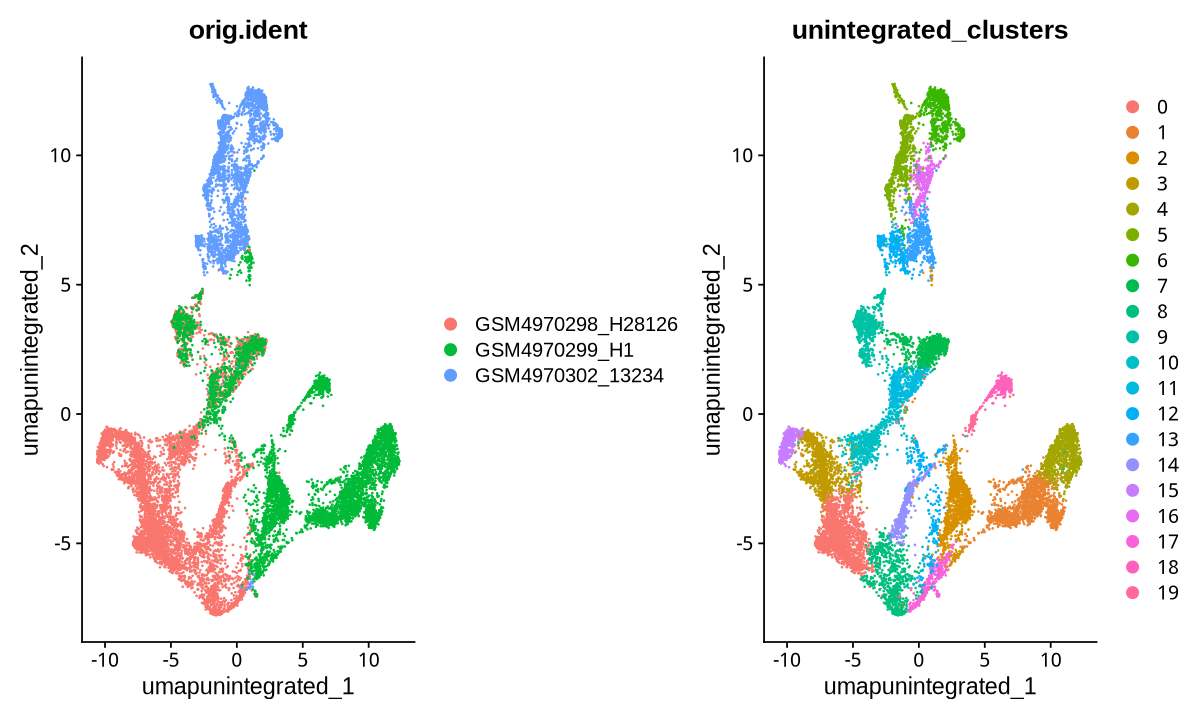

In [10]:
all.genes <- rownames(GSE163018_merge_after_norm)

GSE163018_merge_after_analysis <- GSE163018_merge_after_norm %>%
    FindVariableFeatures() %>%
    ScaleData(features = all.genes) %>%

    RunPCA() %>%
    FindNeighbors(dims = 1:30, reduction = "pca") %>%
    FindClusters(resolution = 0.8, cluster.name = "unintegrated_clusters") %>%
    RunUMAP(dims = 1:30, reduction = "pca", reduction.name = "umap.unintegrated")

DimPlot(object = GSE163018_merge_after_analysis, reduction = "umap.unintegrated", group.by = c("orig.ident", "unintegrated_clusters"))
##FindClusters()関数のresolution引数のdefaultは0.8。

In [34]:
plot_unintegrated <- DimPlot(
  GSE163018_merge_after_analysis,
  reduction = "umap.unintegrated",
  group.by = c("orig.ident", "unintegrated_clusters","seurat_clusters"),
  combine = FALSE, label.size = 2
)

When using repel, set xnudge and ynudge to 0 for optimal results

Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 4499 rows containing missing values or values outside the scale range (`geom_point()`).”


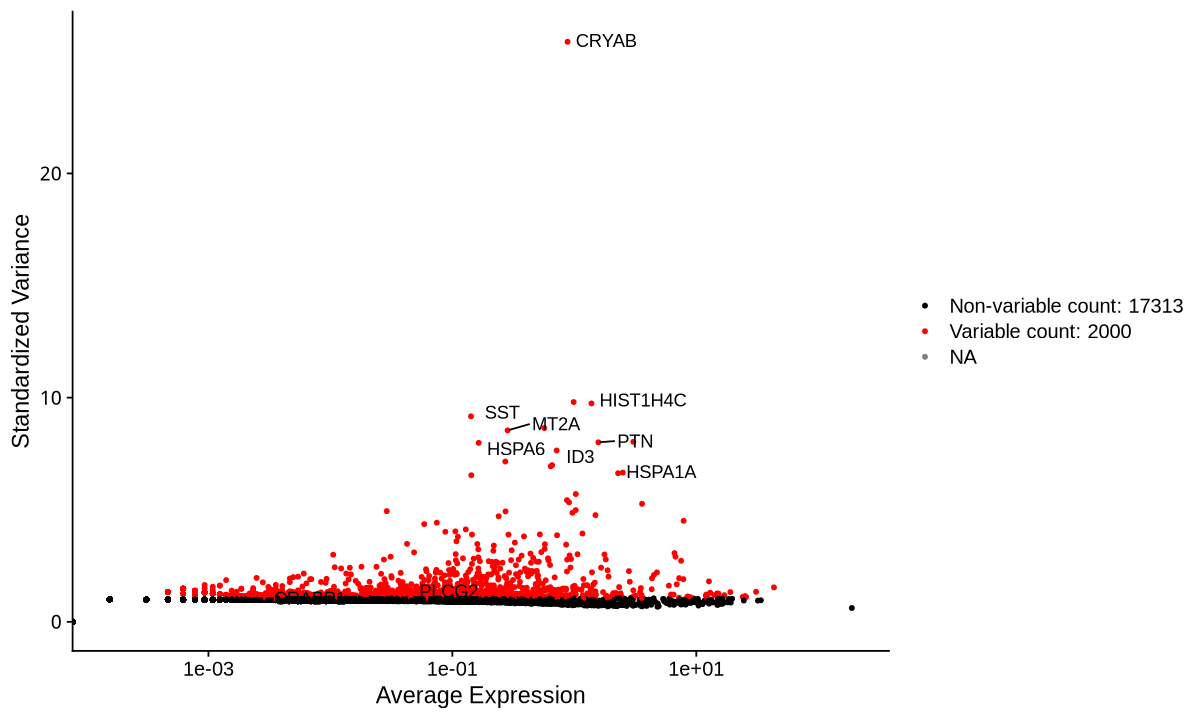

In [11]:
# Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(GSE163018_merge_after_analysis), 10)
# plot variable features with labels
plot1 <- VariableFeaturePlot(GSE163018_merge_after_analysis)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
plot2
##変動が大きい上位10の遺伝子を特定、可視化

## Perform streamlined (one-line) integrative analysis

### Anchor-based CCA integration (method=CCAIntegration)

In [12]:
GSE163018_merge_after_analysis <- IntegrateLayers(
  object = GSE163018_merge_after_analysis, method = CCAIntegration,
  orig.reduction = "pca", new.reduction = "integrated.cca",
  verbose = FALSE
)

GSE163018_merge_after_analysis <- GSE163018_merge_after_analysis %>%
    FindNeighbors(reduction = "integrated.cca", dims = 1:30) %>%
    FindClusters(resolution = 0.8, cluster.name = "cca_clusters") %>%
    RunUMAP(reduction = "integrated.cca", dims = 1:30, reduction.name = "umap.cca")

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 14797
Number of edges: 621720

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8551
Number of communities: 16
Elapsed time: 2 seconds


21:29:49 UMAP embedding parameters a = 0.9922 b = 1.112

21:29:49 Read 14797 rows and found 30 numeric columns

21:29:49 Using Annoy for neighbor search, n_neighbors = 30

21:29:49 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

21:29:51 Writing NN index file to temp file /tmp/RtmppX5XTc/file1c9440644a9e32

21:29:51 Searching Annoy index using 1 thread, search_k = 3000

21:29:54 Annoy recall = 100%

21:29:54 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

21:29:55 Initializing from normalized Laplacian + noise (using RSpectra)

21:29:55 Commencing optimization for 200 epochs, with 668212 positive edges

21:30:02 Optimization finished



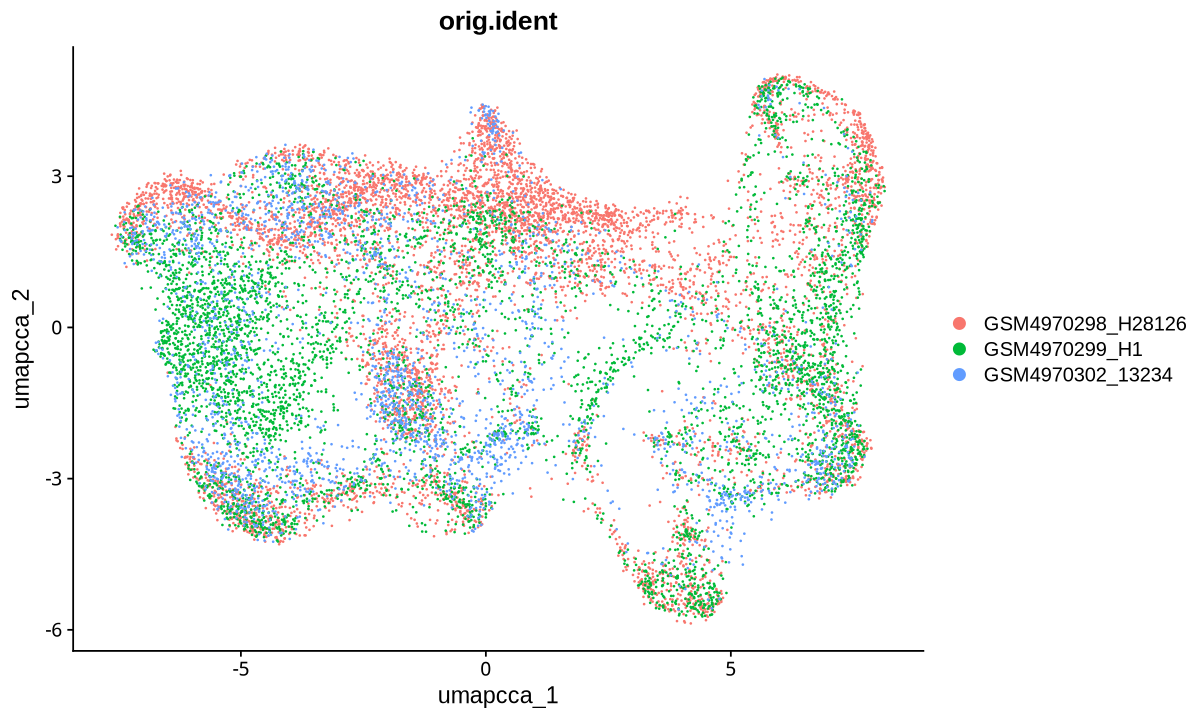

[[1]]

[[2]]

[[3]]


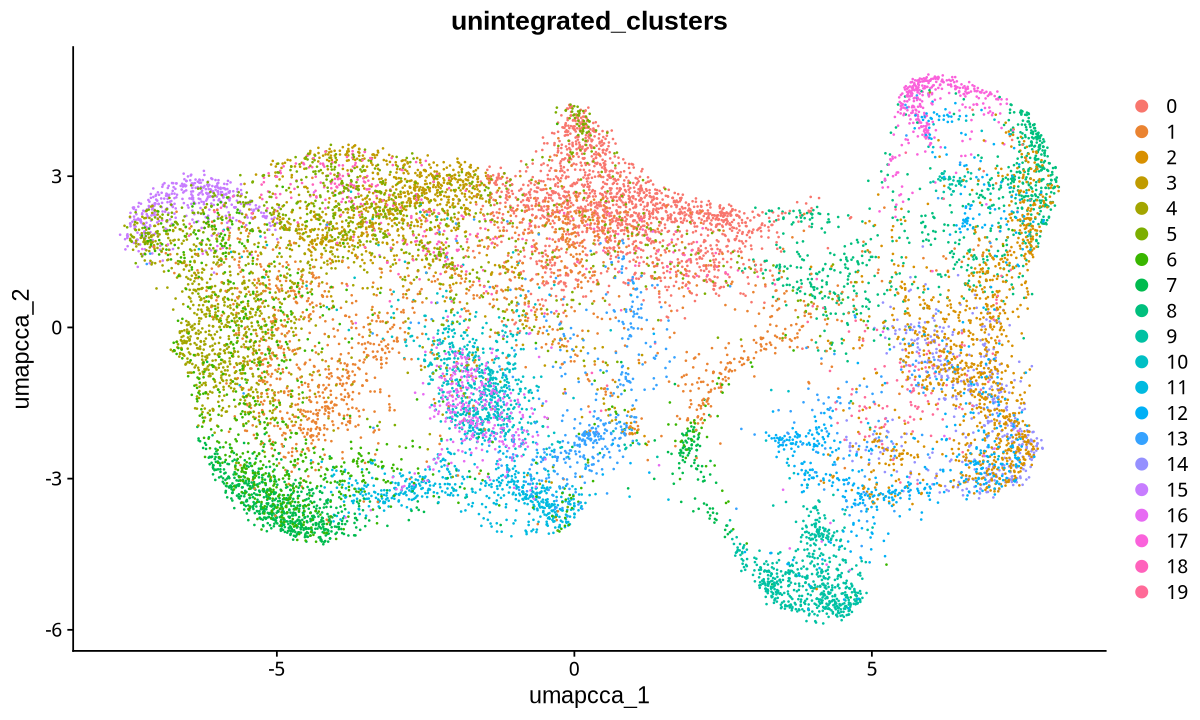

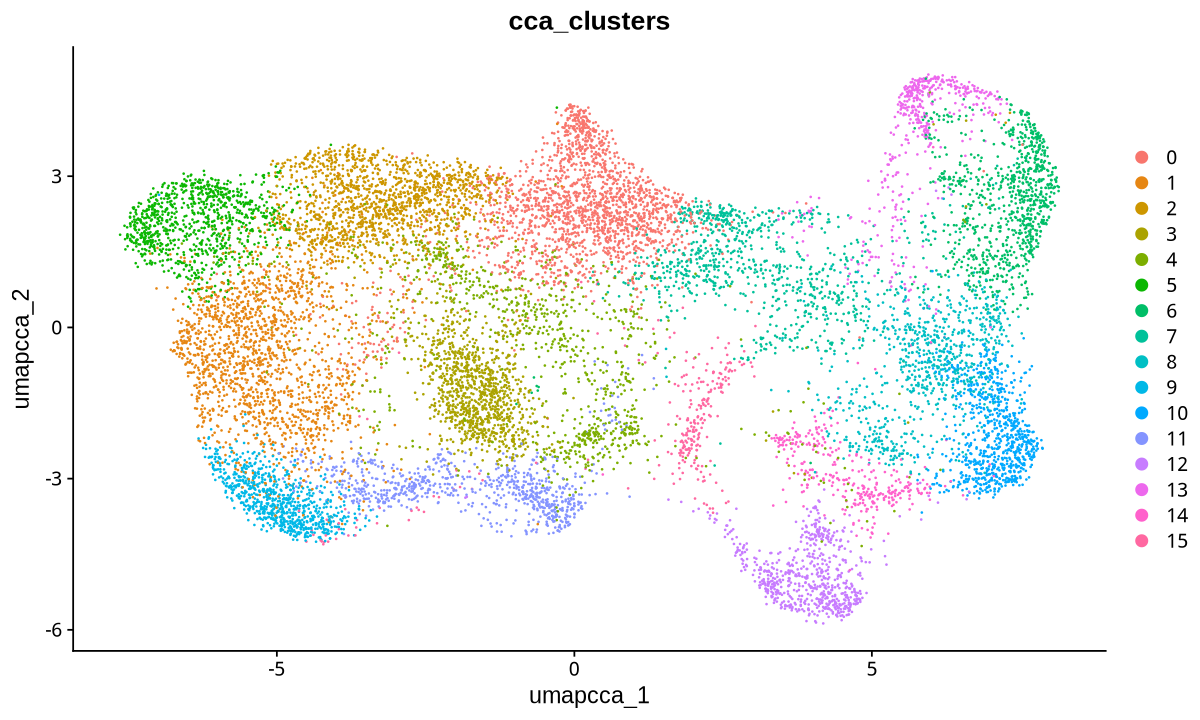

In [19]:
plot_cca <- DimPlot(
  GSE163018_merge_after_analysis,
  reduction = "umap.cca",
  group.by = c("orig.ident", "unintegrated_clusters", "cca_clusters"),
  combine = FALSE, label.size = 2
)
plot_cca

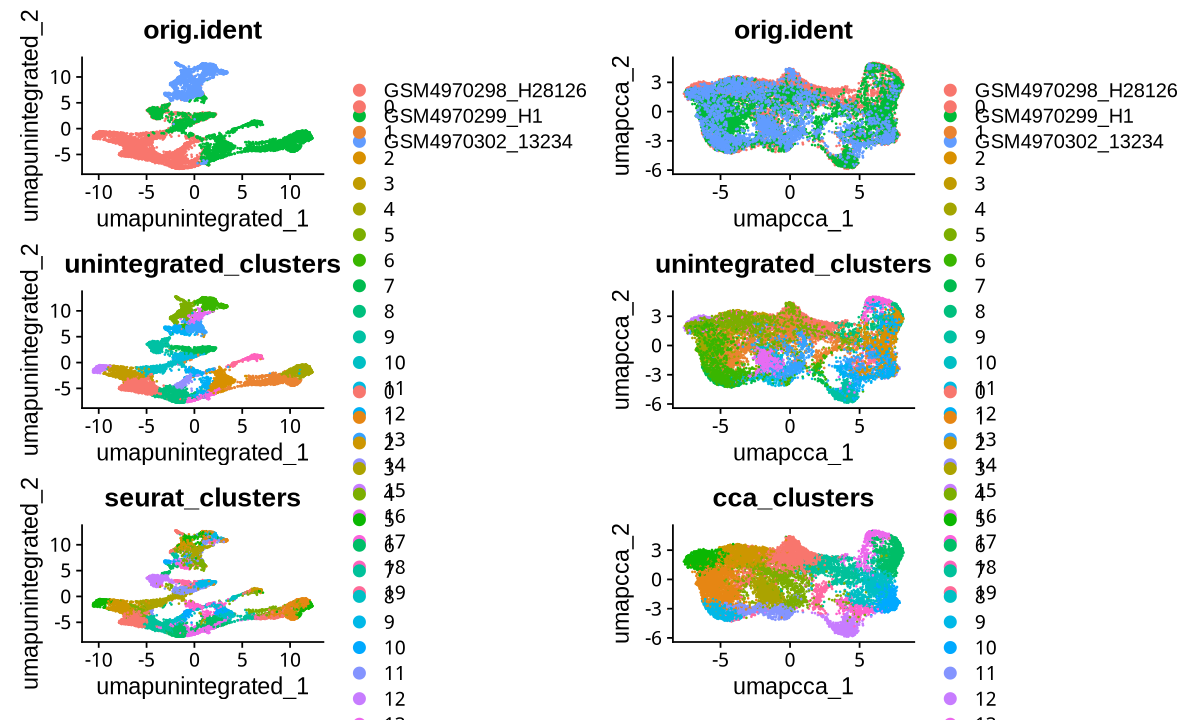

In [35]:
wrap_plots(c(plot_unintegrated, plot_cca), ncol = 2, byrow=F)

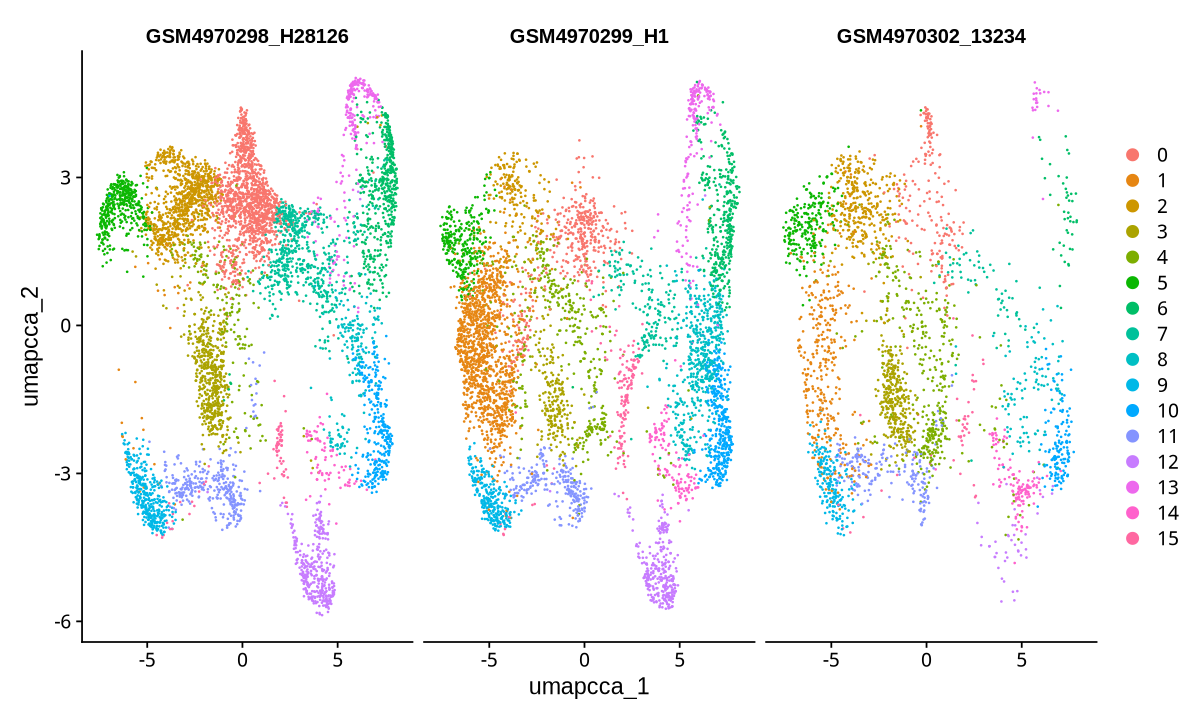

In [36]:
DimPlot(GSE163018_merge_after_analysis,
  reduction = "umap.cca",
  split.by = "orig.ident")

In [37]:
GSE163018_merge_after_analysis
colnames(GSE163018_merge_after_analysis@meta.data)

An object of class Seurat 
23812 features across 14797 samples within 1 assay 
Active assay: RNA (23812 features, 2000 variable features)
 7 layers present: counts.GSM4970298_H28126, counts.GSM4970299_H1, counts.GSM4970302_13234, data.GSM4970298_H28126, data.GSM4970299_H1, data.GSM4970302_13234, scale.data
 4 dimensional reductions calculated: pca, umap.unintegrated, integrated.cca, umap.cca

[1] "orig.ident"            "nCount_RNA"            "nFeature_RNA"         
[4] "percent.mt"            "unintegrated_clusters" "seurat_clusters"      
[7] "cca_clusters"

In [38]:
str(GSE163018_merge_after_analysis)

Formal class 'Seurat' [package "SeuratObject"] with 13 slots
  ..@ assays      :List of 1
  .. ..$ RNA:Formal class 'Assay5' [package "SeuratObject"] with 8 slots
  .. .. .. ..@ layers    :List of 7
  .. .. .. .. ..$ counts.GSM4970298_H28126:Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. .. .. .. .. .. ..@ i       : int [1:8837172] 33 66 69 96 102 107 108 120 123 132 ...
  .. .. .. .. .. .. ..@ p       : int [1:6451] 0 1662 2471 3936 5098 7516 9304 10262 10667 11415 ...
  .. .. .. .. .. .. ..@ Dim     : int [1:2] 19313 6450
  .. .. .. .. .. .. ..@ Dimnames:List of 2
  .. .. .. .. .. .. .. ..$ : NULL
  .. .. .. .. .. .. .. ..$ : NULL
  .. .. .. .. .. .. ..@ x       : num [1:8837172] 1 1 1 15 1 1 1 1 2 2 ...
  .. .. .. .. .. .. ..@ factors : list()
  .. .. .. .. ..$ counts.GSM4970299_H1    :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. .. .. .. .. .. ..@ i       : int [1:9023649] 31 40 126 189 245 262 280 290 299 314 ...
  .. .. .. .. .. .. ..@ p       : in

In [39]:
GSE163018_merge_after_analysis <- JoinLayers(GSE163018_merge_after_analysis)
GSE163018_merge_after_analysis

An object of class Seurat 
23812 features across 14797 samples within 1 assay 
Active assay: RNA (23812 features, 2000 variable features)
 3 layers present: data, counts, scale.data
 4 dimensional reductions calculated: pca, umap.unintegrated, integrated.cca, umap.cca

In [40]:
str(GSE163018_merge_after_analysis)

Formal class 'Seurat' [package "SeuratObject"] with 13 slots
  ..@ assays      :List of 1
  .. ..$ RNA:Formal class 'Assay5' [package "SeuratObject"] with 8 slots
  .. .. .. ..@ layers    :List of 3
  .. .. .. .. ..$ data      :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. .. .. .. .. .. ..@ i       : int [1:22343626] 33 66 69 96 102 107 108 120 123 132 ...
  .. .. .. .. .. .. ..@ p       : int [1:14798] 0 1662 2471 3936 5098 7516 9304 10262 10667 11415 ...
  .. .. .. .. .. .. ..@ Dim     : int [1:2] 23812 14797
  .. .. .. .. .. .. ..@ Dimnames:List of 2
  .. .. .. .. .. .. .. ..$ : NULL
  .. .. .. .. .. .. .. ..$ : NULL
  .. .. .. .. .. .. ..@ x       : num [1:22343626] 1.18 1.18 1.18 3.55 1.18 ...
  .. .. .. .. .. .. ..@ factors : list()
  .. .. .. .. ..$ counts    :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. .. .. .. .. .. ..@ i       : int [1:22343626] 33 66 69 96 102 107 108 120 123 132 ...
  .. .. .. .. .. .. ..@ p       : int [1:14798] 0 1662 24

In [41]:
saveRDS(GSE163018_merge_after_analysis, file = paste0(out_f_SeuratObject,"/GSE163018_merge_after_analysis_cca.rds"))

# Finding differentially expressed features (cluster biomarkers)

In [42]:
# find markers for every cluster compared to all remaining cells, report only the positive
# ones
markers_merge_cca <- FindAllMarkers(GSE163018_merge_after_analysis, only.pos = TRUE)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13

Calculating cluster 14

Calculating cluster 15



In [43]:
markers_merge_cca_cut <- markers_merge_cca %>%
    group_by(cluster) %>%
    dplyr::filter(avg_log2FC > 1) %>%
    dplyr::filter(p_val_adj < 0.05)
##p_val_adjが小さい順に
##各クラスターのマーカー遺伝子のうち、平均対数fold change（avg_log2FC）が1を超える、補正p値が0.05未満のものだけを抽出
head(markers_merge_cca_cut)

p_val         avg_log2FC pct.1 pct.2 p_val_adj     cluster gene    
1  0.000000e+00 2.499593   0.706 0.248  0.000000e+00 0       DLX6-AS1
2  0.000000e+00 1.710813   0.618 0.209  0.000000e+00 0       DLX5    
3 1.309835e-262 2.443688   0.325 0.071 3.118980e-258 0       SYNPR   
4 1.048759e-256 1.720986   0.519 0.183 2.497306e-252 0       DLX1    
5 1.090889e-254 2.330026   0.535 0.211 2.597625e-250 0       HSPA1A  
6 1.606543e-227 1.975684   0.528 0.216 3.825499e-223 0       HSPA1B

In [44]:
write.csv(markers_merge_cca_cut, file = paste0(out_f_genelist,"/GSE163018_merge_cca_markers_cut.csv"), col.names = T, row.names = T)

Warning message in write.csv(markers_merge_cca_cut, file = paste0(out_f_genelist, :
“ 'col.names' への変更の試みは無視されました ”


In [45]:
markers_merge_cca_cut_summarize <- markers_merge_cca_cut %>%
    group_by(cluster) %>%
    summarize(marker_genes_n = n())
markers_merge_cca_cut_summarize
write.csv(markers_merge_cca_cut_summarize, file = paste0(out_f_genelist,"/GSE163018_merge_cca_markers_cut_summarise.csv"), col.names = T, row.names = F)

cluster marker_genes_n
1  0         96          
2  1        541          
3  2        343          
4  3         63          
5  4        595          
6  5        995          
7  6        683          
8  7        239          
9  8        503          
10 9        251          
11 10      1139          
12 11        48          
13 12       453          
14 13       527          
15 14       302          
16 15       133

Warning message in write.csv(markers_merge_cca_cut_summarize, file = paste0(out_f_genelist, :
“ 'col.names' への変更の試みは無視されました ”


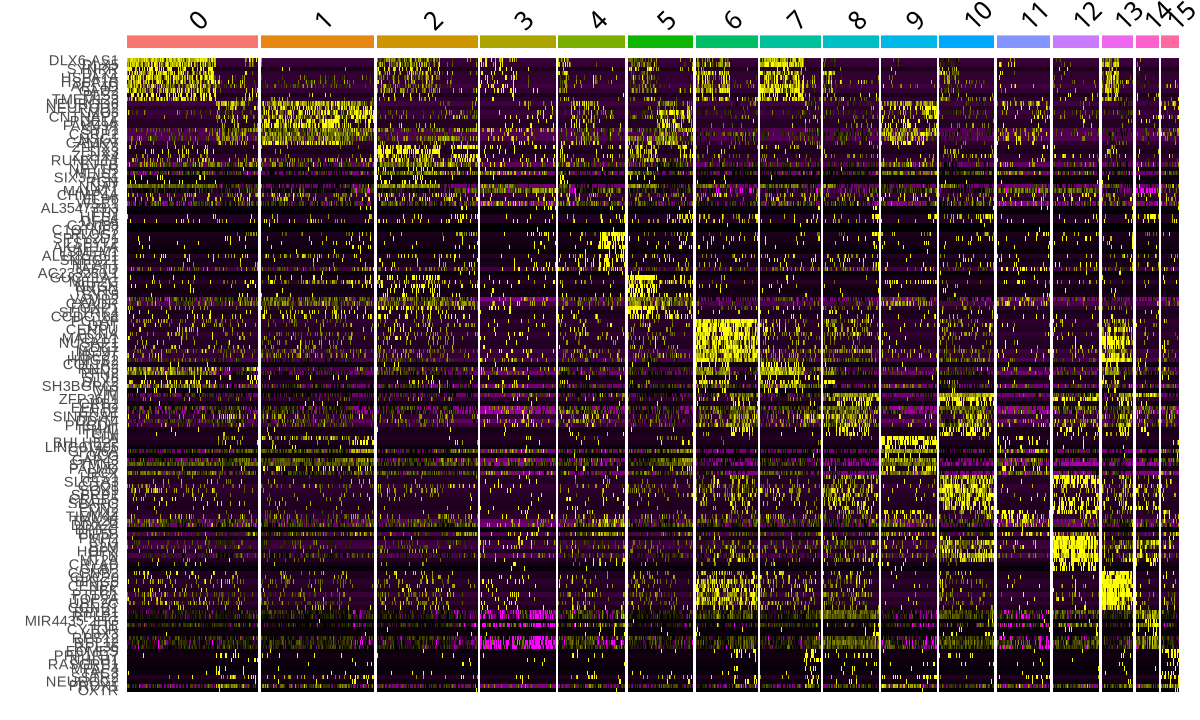

In [46]:
markers_merge_cca_cut %>%
    group_by(cluster) %>%
    slice_head(n = 10) %>%
    ungroup() -> top10
# ヒートマップを作成
heatmap_plot <- DoHeatmap(GSE163018_merge_after_analysis, features = top10$gene) + NoLegend()
heatmap_plot
##pbmc オブジェクトから上位10のマーカーを抽出し、その発現をヒートマップとして可視化
##各クラスターに特異的なマーカー遺伝子の発現パターンを視覚的に把握することができる
##NoLegend() ：加えることで、図の凡例を表示しないteractive

In [47]:
# ggsaveで保存
ggsave(file = paste0(out_f_plot,"/GSE163018_merge_cca_markers_cut_heatmap_top10_genes.png"), plot = heatmap_plot, width = 10, height = 18, dpi = 300)

In [48]:
neuronal_cell_markers <- read.csv(file = "/home/oguma/reference/scRNA-seq_neuron_markers.csv", header = T)
neuronal_cell_markers

celltype                                           celltype2         
1  radial glia                                        RGs               
2  radial glia                                        RGs               
3  radial glia                                        RGs               
4  radial glia                                        RGs               
5  radial glia                                        RGs               
6  intermediate progeniter cells                      IPCs              
7  upper layer(cortical layers Ⅱ-Ⅳ)excitatory neurons ulENs             
8  deep layer(cortical layers Ⅴ-Ⅵ)excitatory neurons  dlENs             
9  deep layer(cortical layers Ⅴ-Ⅵ)excitatory neurons  dlENs             
10 interneurons                                       interneurons      
11 excitatory neurons                                 excitatory neurons
12 excitatory neurons                                 excitatory neurons
13 medial ganglionic eminence                         MGE cells         
14 glia/astrocytes                                    glia/astrocytes   
15 outer radial glia                                  oRGs              
16 microglia                                          microglia         
17 truncated radial glia                              tRGs              
18 MGE-derived interneurons                           IN-MGEs           
19 oligodendrocyte precursors                         OPCs              
   marker_genes
1  SOX2        
2  GFAP        
3  HES1        
4  PAX6        
5  GLI3        
6  EOMES       
7  SATB2       
8  CRYM        
9  FEZF2       
10 DLX1        
11 NEUROD2     
12 TBR1        
13 NKX2.1      
14 AQP4        
15 HOPX        
16 CCL4        
17 CRYAB       
18 LHX6        
19 OLIG1

Warning message:
“The following requested variables were not found: NKX2.1”


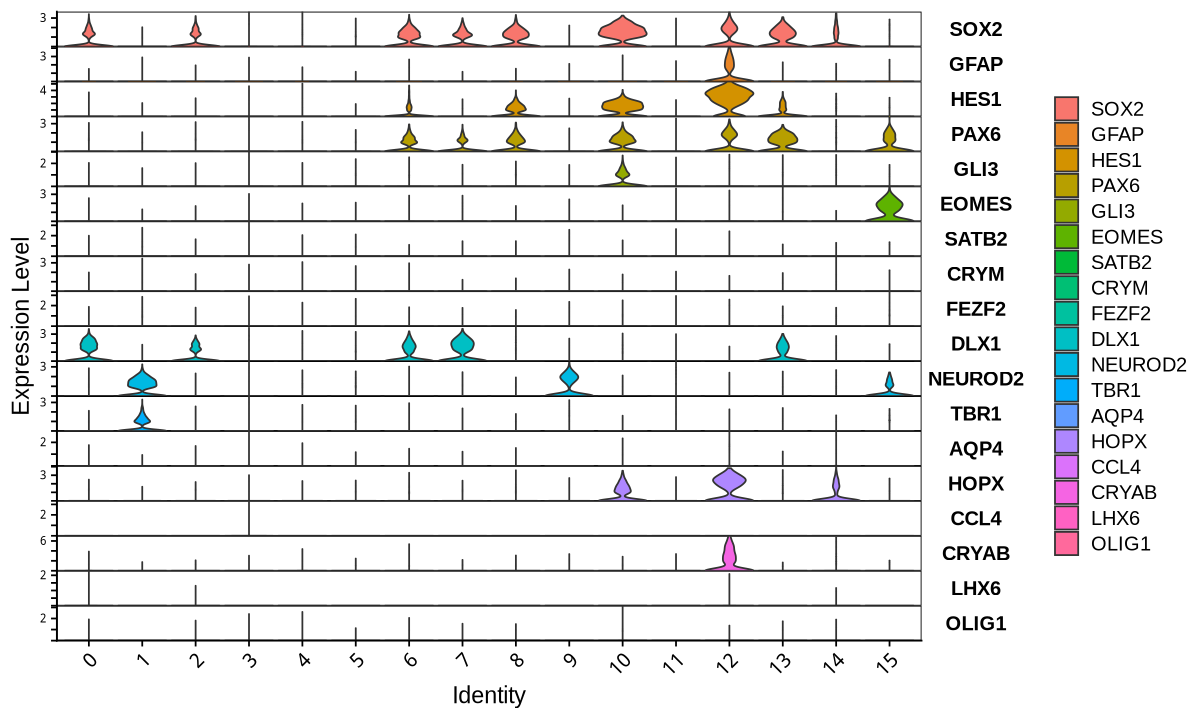

In [49]:
vlnplot_neuronal_cell_markers <- VlnPlot(GSE163018_merge_after_analysis, features = neuronal_cell_markers$marker_genes,stack=T,flip=T)
vlnplot_neuronal_cell_markers

In [50]:
# ggsaveで保存
ggsave(file = paste0(out_f_plot,"/GSE163018_merge_cca_markers_cut_vlnplot_neuronal_cell_markers.png"), plot = vlnplot_neuronal_cell_markers, width = 10, height = 15, dpi = 300)

Warning message:
“The following requested variables were not found: NKX2.1”


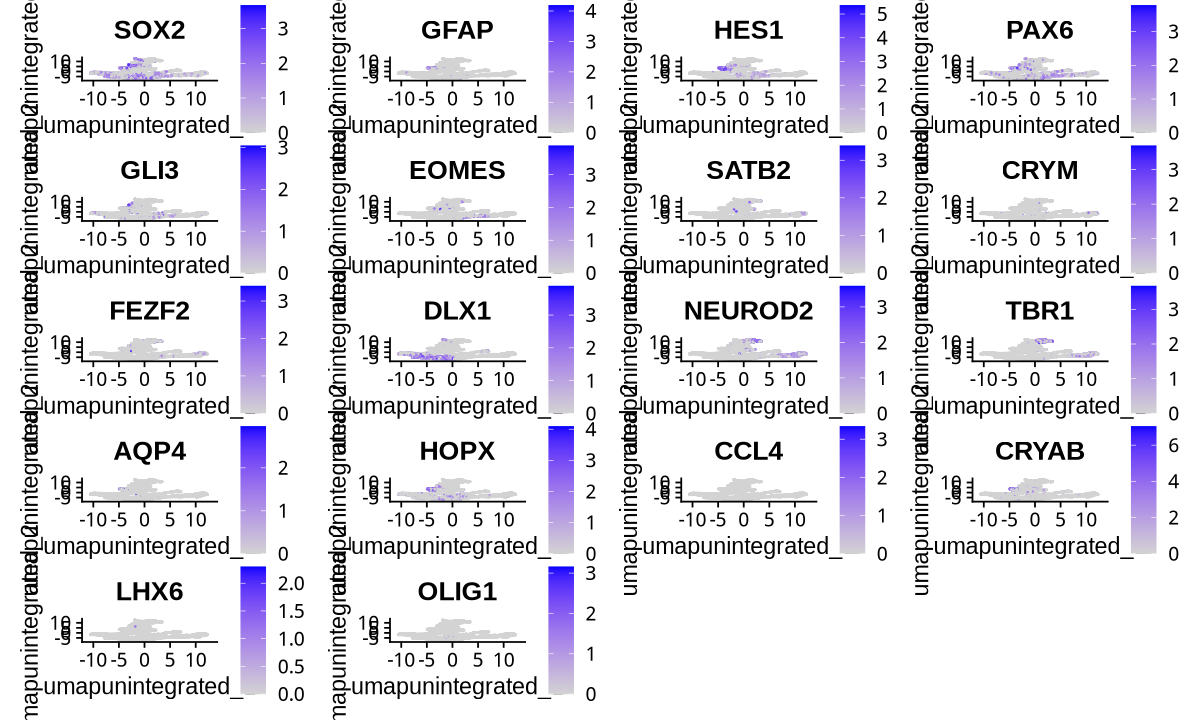

In [51]:
#FeaturePlot(SeuratObject, features = filter(neuronal_cell_markers,celltype2=="RGs")$marker_genes) 
FeaturePlot_neuronal_cell_markers <- FeaturePlot(GSE163018_merge_after_analysis, features = neuronal_cell_markers$marker_genes)
##指定した遺伝子の発現をt-SNEまたはUMAPプロット上に可視化（各プロットは、指定した遺伝子の発現レベルを色で示している。）
##特定の遺伝子が異なる細胞集団にどのように分布しているか→細胞の特性や機能を理解するために役立つ
FeaturePlot_neuronal_cell_markers

In [52]:
# ggsaveで保存
ggsave(paste0(out_f_plot,"/GSE163018_merge_cca_markers_cut_FeaturePlot_neuronal_cell_markers.png"), plot = FeaturePlot_neuronal_cell_markers, width = 10, height = 10, dpi = 300)

In [53]:
#cluster_celltype <- left_join(neuronal_cell_markers, markers_cut, by = c("marker_genes" = "gene"))
cluster_celltype <- inner_join(markers_merge_cca_cut, neuronal_cell_markers, by = c("gene" = "marker_genes"))
cluster_celltype

p_val         avg_log2FC pct.1 pct.2 p_val_adj     cluster gene   
1  1.048759e-256 1.720986   0.519 0.183 2.497306e-252 0       DLX1   
2   0.000000e+00 2.263213   0.660 0.110  0.000000e+00 1       NEUROD2
3   0.000000e+00 2.521851   0.440 0.057  0.000000e+00 1       TBR1   
4  7.873086e-176 2.404773   0.185 0.029 1.874739e-171 1       FEZF2  
5  9.624081e-148 2.493534   0.130 0.016 2.291686e-143 1       SATB2  
6   8.376963e-31 1.956293   0.053 0.013  1.994722e-26 1       CRYM   
7   7.697566e-09 1.015970   0.065 0.030  1.832944e-04 6       EOMES  
8  1.472796e-153 1.760681   0.571 0.204 3.507023e-149 7       DLX1   
9   3.576541e-33 1.568876   0.102 0.028  8.516459e-29 7       EOMES  
10  1.628215e-34 1.064090   0.177 0.062  3.877104e-30 8       GLI3   
11 2.293624e-116 2.230158   0.434 0.157 5.461577e-112 9       NEUROD2
12  3.484239e-12 1.393046   0.164 0.096  8.296671e-08 9       TBR1   
13  0.000000e+00 1.062226   0.741 0.131  0.000000e+00 10      HES1   
14 1.073178e-258 2.633545   0.367 0.052 2.555452e-254 10      GLI3   
15 3.912995e-205 1.664826   0.779 0.284 9.317623e-201 10      SOX2   
16 1.808111e-197 1.863946   0.489 0.114 4.305475e-193 10      HOPX   
17 8.908901e-124 1.307730   0.576 0.207 2.121388e-119 10      PAX6   
18  1.285700e-91 3.335835   0.088 0.008  3.061509e-87 10      OLIG1  
19  1.319424e-19 1.146627   0.041 0.008  3.141814e-15 10      AQP4   
20  0.000000e+00 5.245337   0.829 0.132  0.000000e+00 12      HES1   
21  0.000000e+00 3.838509   0.604 0.112  0.000000e+00 12      HOPX   
22  0.000000e+00 6.860663   0.479 0.051  0.000000e+00 12      CRYAB  
23  0.000000e+00 7.167866   0.352 0.008  0.000000e+00 12      GFAP   
24 2.471756e-186 5.336161   0.118 0.005 5.885746e-182 12      AQP4   
25  2.513318e-41 1.708172   0.392 0.219  5.984713e-37 12      PAX6   
26  6.615638e-20 1.156636   0.414 0.306  1.575316e-15 12      SOX2   
27  1.893465e-12 1.996957   0.130 0.066  4.508719e-08 12      GLI3   
28  3.363749e-90 1.430410   0.618 0.215  8.009759e-86 13      PAX6   
29  2.466421e-17 1.613887   0.283 0.131  5.873041e-13 14      HOPX   
30  0.000000e+00 5.053994   0.549 0.023  0.000000e+00 15      EOMES  
31  7.857538e-12 1.197512   0.383 0.224  1.871037e-07 15      PAX6   
   celltype                                           celltype2         
1  interneurons                                       interneurons      
2  excitatory neurons                                 excitatory neurons
3  excitatory neurons                                 excitatory neurons
4  deep layer(cortical layers Ⅴ-Ⅵ)excitatory neurons  dlENs             
5  upper layer(cortical layers Ⅱ-Ⅳ)excitatory neurons ulENs             
6  deep layer(cortical layers Ⅴ-Ⅵ)excitatory neurons  dlENs             
7  intermediate progeniter cells                      IPCs              
8  interneurons                                       interneurons      
9  intermediate progeniter cells                      IPCs              
10 radial glia                                        RGs               
11 excitatory neurons                                 excitatory neurons
12 excitatory neurons                                 excitatory neurons
13 radial glia                                        RGs               
14 radial glia                                        RGs               
15 radial glia                                        RGs               
16 outer radial glia                                  oRGs              
17 radial glia                                        RGs               
18 oligodendrocyte precursors                         OPCs              
19 glia/astrocytes                                    glia/astrocytes   
20 radial glia                                        RGs               
21 outer radial glia                                  oRGs              
22 truncated radial glia                              tRGs              
23 radial glia                                        RGs               
24 glia/ast

In [54]:
write.csv(cluster_celltype, file = paste0(out_f_genelist,"/GSE163018_merge_cca_markers_cut_joined_neuronal_cell_markers.csv"), col.names = T, row.names = F)

Warning message in write.csv(cluster_celltype, file = paste0(out_f_genelist, "/GSE163018_merge_cca_markers_cut_joined_neuronal_cell_markers.csv"), :
“ 'col.names' への変更の試みは無視されました ”


# gene_listの作成→Bed fileをGRCh37で作成する

In [55]:
for ( i in markers_merge_cca_cut_summarize$cluster ) {
    markers_cut_cluster <- markers_merge_cca_cut %>%
        dplyr::filter(cluster == i)
    marker_genes <- markers_cut_cluster[7]
    OFILE=paste0(out_f_genelist,"/GSE163018_merge_cca_markergenes_",i,".txt") #ここは適当に変更
    write.table(marker_genes, OFILE, col.names=T, row.names=F, append=F, quote=F, sep="\t")
    }

## gene_listをSYMBOL→ENSEMBLに変換

In [56]:
library(org.Hs.eg.db)
library(AnnotationDbi)

library(dplyr)
library(tidyverse)


options(stringsAsFactors=F) #文字列が自動的にfactor型に変換されるのを防ぐ。文字列がデフォルトで文字型のまま扱われる。デフォルトでF
options(scipen=100)　　#指数表記を回避

 要求されたパッケージ AnnotationDbi をロード中です 

 要求されたパッケージ stats4 をロード中です 

 要求されたパッケージ BiocGenerics をロード中です 


 次のパッケージを付け加えます: ‘BiocGenerics’ 


 以下のオブジェクトは ‘package:lubridate’ からマスクされています:

    intersect, setdiff, union


 以下のオブジェクトは ‘package:SeuratObject’ からマスクされています:

    intersect


 以下のオブジェクトは ‘package:dplyr’ からマスクされています:

    combine, intersect, setdiff, union


 以下のオブジェクトは ‘package:stats’ からマスクされています:

    IQR, mad, sd, var, xtabs


 以下のオブジェクトは ‘package:base’ からマスクされています:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


 要求されたパッケージ Biobase をロード中です 

Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVi

In [57]:
dir.create(paste0(out_f_genelist,"/GSE163018_merge_cca_marker_gene_list"))

In [58]:
anno_df_cluster_size <- NA
for ( i in markers_merge_cca_cut_summarize$cluster ) {
    file_path=paste0(out_f_genelist,"/GSE163018_merge_cca_markergenes_",i,".txt")
    df=read.table(file_path, header=1)
    key_genes=df$gene

    ##遺伝子シンボル (key_genes) を使って対応するSYMBOLとENSEMBLを取得
    annotTable <- AnnotationDbi::select(org.Hs.eg.db,
        keys = key_genes,
        columns = c('SYMBOL', 'ENSEMBL'),
        keytype = 'SYMBOL')
    ##ENSEMBL IDが欠けていない行だけを抽出
    anno_df <- annotTable[!is.na(annotTable$ENSEMBL),]
    colnames(anno_df) <- c("human_symbol", "human_gene_ENSG")
    ##各クラスターのmarker genesの数（ENSEMBL IDが欠けていないもののみ）
    anno_df_cluster_size <- c(anno_df_cluster_size, nrow(anno_df))
    
    #human_gene_ENSGの列のみ取り出して、gene_listの作成
    marker_gene_list <- anno_df[2]
    colnames(marker_gene_list) <- c("gene")
    
    OFILE=paste0(out_f_genelist,"/GSE163018_merge_cca_marker_gene_list/marker_gene_list_",i,".txt") #ここは適当に変更
    write.table(marker_gene_list,OFILE,row.names=FALSE,col.names=TRUE, sep="\t", append=F, quote=F)
}

'select()' returned 1:many mapping between keys and columns

'select()' returned 1:many mapping between keys and columns

'select()' returned 1:many mapping between keys and columns

'select()' returned 1:many mapping between keys and columns

'select()' returned 1:many mapping between keys and columns

'select()' returned 1:many mapping between keys and columns

'select()' returned 1:many mapping between keys and columns

'select()' returned 1:many mapping between keys and columns

'select()' returned 1:many mapping between keys and columns

'select()' returned 1:many mapping between keys and columns

'select()' returned 1:many mapping between keys and columns

'select()' returned 1:many mapping between keys and columns

'select()' returned 1:many mapping between keys and columns

'select()' returned 1:many mapping between keys and columns

'select()' returned 1:many mapping between keys and columns

'select()' returned 1:many mapping between keys and columns



In [59]:
anno_df_cluster_size

[1]   NA  102  539  314   69  545  978  702  257  481  261 1118   48  466  538
[16]  307  150

In [60]:
markers_merge_cca_cut_summarize <- cbind(markers_merge_cca_cut_summarize, anno_df_cluster_size[-1])
colnames(markers_merge_cca_cut_summarize) <- c(colnames(markers_merge_cca_cut_summarize)[1:2],"marker_genes_anno_n")
markers_merge_cca_cut_summarize
write.csv(markers_merge_cca_cut_summarize, file = paste0(out_f_genelist,"/GSE163018_merge_cca_markers_cut_summarise.csv"), col.names = T, row.names = F)

cluster marker_genes_n marker_genes_anno_n
1  0         96            102               
2  1        541            539               
3  2        343            314               
4  3         63             69               
5  4        595            545               
6  5        995            978               
7  6        683            702               
8  7        239            257               
9  8        503            481               
10 9        251            261               
11 10      1139           1118               
12 11        48             48               
13 12       453            466               
14 13       527            538               
15 14       302            307               
16 15       133            150

Warning message in write.csv(markers_merge_cca_cut_summarize, file = paste0(out_f_genelist, :
“ 'col.names' への変更の試みは無視されました ”


## ENSEMBLのgene_listをregionに変換する

参考（20241011_tutorial_genelist_yukioguma.ipynb）

- 遺伝子リストからBed fileをGRCh37で作成する
- gencode Release 26 (GRCh37)
- Comprehensive gene annotationの"transcript"行かつ"basic" tagの最初から最後までをgene領域と定義した

In [61]:
gft_df=read.table("/home/k1_taka/reference/gencode/gene_region.bed")
colnames(gft_df)=c("CHR", "START", "END","genes")
nrow(gft_df) #58288

[1] 59936

In [62]:
gft_df2 <- gft_df %>% 
    separate(genes, c("gene", "ver"), "\\.") %>% 
    dplyr::select(c("gene", "CHR", "START", "END"))

gft_df3 <- gft_df2[!(duplicated(gft_df2$gene) | duplicated(gft_df2$gene, fromLast = TRUE)),] 
##gene列に一度も重複が存在しない行だけが残る
##gft_df3 <- gft_df2 %>% dplyr::distinct(gene) #だと、重複するものは最初だけ残す、行全体(gene以外も)を残す

rownames(gft_df3)=gft_df3$gene

head(gft_df3)

gene            CHR   START     END      
ENSG00000000003 ENSG00000000003 chrX   99882106  99892101
ENSG00000000005 ENSG00000000005 chrX   99839799  99854882
ENSG00000000419 ENSG00000000419 chr20  49551404  49575092
ENSG00000000457 ENSG00000000457 chr1  169818772 169863100
ENSG00000000460 ENSG00000000460 chr1  169763871 169823221
ENSG00000000938 ENSG00000000938 chr1   27938575  27961788

In [63]:
dir_path=paste0(out_f_genelist,"/GSE163018_merge_cca_marker_gene_list")
out_f=paste0(dir_path, "/gene_region_v26")
dir.create(out_f)

In [64]:
for ( i in markers_merge_cca_cut_summarize$cluster ) {
    gene_list=paste0("marker_gene_list_",i,".txt")
    df=read.table(paste0(dir_path,"/", gene_list), header=1)
    bed_df=gft_df3[df$gene,] %>% dplyr::select(c("CHR", "START", "END"))
    bed_df_woNA=na.omit(bed_df)
    data_name=strsplit(gene_list, "\\.")
    write.table(bed_df_woNA,paste0(out_f, "/", data_name[[1]][1], "_region.bed"),row.names=FALSE,col.names=FALSE, sep="\t", append=F, quote=F)
## output：
#dir_pathフォルダ内のgene_region_v26フォルダに「gene_listの拡張子まで+"_region.bed"」というファイルができている。
#ex. gene_list="gene_name.txt"としたら、"gene_name_region.bed"というファイルができている
}

### オプション：region fileのgene領域の前後100kBを含むように延長する

In [ ]:
#login→working directoryへ移動
qlogin -l s_vmem=16G
export MKL_NUM_THREADS=1
export OMP_NUM_THREADS=1
export MKL_DOMAIN_NUM_THREADS=1
unset PROMPT_COMMAND
##unset PROMPT_COMMANDは改行のエラーを防ぐための呪文

out_f=/home/oguma/work/seurat/test2_GSE163018_scRNA-seq_cerebral_organoid_integrate_cca
out_f_genelist=${out_f}/genelist

dir_path=${out_f_genelist}/GSE163018_merge_cca_marker_gene_list
cd ${dir_path}
out_f2=${dir_path}/gene_region_v26_100KB_ext
mkdir ${out_f2}
mkdir -p log
export PATH=/home/k1_taka/miniconda3/envs/renv/bin:${PATH}

cluster=$(awk -F ',' '{print $1}' ${out_f_genelist}/GSE163018_merge_cca_markers_cut_summarise.csv | awk 'NR>=2' | tr '\n' ' ' | tr -d '"')
##awk コマンドで取得したクラスター番号が複数行の場合、改行をスペースに変換して1つずつ扱えるようにしている。これにより for ループで各クラスター番号を個別に処理できる。""を消す

In [ ]:
#ターミナルで実行
for cluster in $cluster
do
    gene_list="marker_gene_list_${cluster}.txt"
    filename=`echo $gene_list | cut -d "." -f 1`
    ##gene_list からファイル名（拡張子を除く）を取得
    bedtools slop -i ${dir_path}/gene_region_v26/${filename}_region.bed -g /home/k1_taka/reference/chrom.sizes -b 100000 > ${out_f2}/${filename}_region_hg19_ext100Kbp.bed 2> log/error_log.txt
##output###
#${dir_path}/gene_region_v26_100KB_extファイルに「gene_listの拡張子まで+"_region_hg19_ext100Kbp.bed"」というファイルができる
done